In [63]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 2060
Using device: cuda


In [64]:
import pandas as pd
import numpy as np
import mne
import os
import matplotlib.pyplot as plt

In [65]:
from eeg_lib.commons.constant import DATASETS_FOLDER
from eeg_lib.data.data_loader.EEGDataExtractor import EEGDataExtractor

In [66]:
from eeg_lib.utils.engine import create_user_profiles

In [67]:
from eeg_lib.utils.helpers import compute_genuine_imposter_distances, compute_threshold_metrics, compute_f1_vs_threshold, split_test_data_for_verification

In [68]:
from eeg_lib.utils.visualisations import plot_distance_distribution_on_ax, plot_threshold_metrics, plot_f1_vs_threshold, plot_distance_distribution_return, plot_f1_vs_threshold_return, plot_threshold_metrics_return

In [ ]:
DATA_DIR = f"{DATASETS_FOLDER}/Kolory/"

extractor = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants_info = extractor.extract_dataframe()

In [70]:
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap

In [71]:
from sklearn.model_selection import ParameterGrid

In [72]:
import torch.nn as nn

In [73]:
from eeg_lib.data.data_loader.TDNNFeatures import extract_features
from eeg_lib.data.TDNNDataset import TDNNDataset
from eeg_lib.models.verification.XVector import XVectorEmbeddingModel
from eeg_lib.losses.ProxyNCALoss import ProxyNCALoss
from eeg_lib.utils.visualisations import plot_tsne
from eeg_lib.utils.visualisations import create_handles
from eeg_lib.utils.helpers import split_train_test
from eeg_lib.models.similarity.centroids import SimilarityCentroidsVerifier

In [74]:
from torch.utils.tensorboard import SummaryWriter

In [75]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

## Hyperparameters

In [76]:
grid = {
    "batch_size" : [64],
    "softmax_learning_rate" : [0.001, 0.01],
    "proxy_learning_rate" : [0.001, 0.05, 0.01],
    "softmax_epochs" : [50,75,100,150],
    "proxy_epochs" : [50,75,100,150],
    "softmax_learning_rate_decay" : [0.95],
    "proxy_learning_rate_decay" : [0.95],
    "augmentation" : [True],
    "std" : [0.02],
    "embedding_dim" : [32],
    "dropout_rate" : [0.25],
    "scale" : [7],
    "layer1_filters" : [512],
    "layer2_filters" : [512],
    "layer3_filters" : [1024],
    "layer4_filters" : [1024],
    "layer5_filters" : [1500],
    "layer_1_dilatation" : [1],
    "layer_2_dilatation" : [2],
    "layer_3_dilatation" : [3],
    "layer_1_stride" : [1],
    "layer_2_stride" : [1],
    "layer_3_stride" : [2],
}

## Feature extraction

In [77]:
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = split_train_test(eeg_df=eeg_df,test_size=0.2, random_state=42)

Training set participants: ['fd8a3308@1135' 'e08138e2@1731' '541c91f2@1456' '011595b1@1651'
 '2718372d@1400' '6e542bc2@0845' '2882ae26@1441' '548fd734@1628'
 '51ec2c20@0923' 'bf2d2193@1638' '022e8467@1910' '06f240e9@1215'
 'e283301e@1606' '25d0bdb3@1318' 'b34b1427@0906' 'e43a9f9f@0941'
 '8dca0725@1418' 'ffae50df@1712' '9e8bae0e@1828' '36eea4bb@1519'
 '46607ce4@1717' '54e60118@1339' '90441f44@1643' '3033b74a@1626']
Test set participants: ['f82b5699@1757' '6d9a8b86@1613' 'd87e1bd3@1806' '8bd3032e@1746'
 '39285860@1825' '446b3735@1618']
Training labels: ['011595b1@1651' '022e8467@1910' '06f240e9@1215' '25d0bdb3@1318'
 '2718372d@1400' '2882ae26@1441' '3033b74a@1626' '36eea4bb@1519'
 '46607ce4@1717' '51ec2c20@0923' '541c91f2@1456' '548fd734@1628'
 '54e60118@1339' '6e542bc2@0845' '8dca0725@1418' '90441f44@1643'
 '9e8bae0e@1828' 'b34b1427@0906' 'bf2d2193@1638' 'e08138e2@1731'
 'e283301e@1606' 'e43a9f9f@0941' 'fd8a3308@1135' 'ffae50df@1712']
Test labels: ['39285860@1825' '446b3735@1618' '6d9a8

feature extraction similar to Mel frequency cepstral coefficients

In [78]:
extracted_X_train = []
for epoch in X_train_tmp:
    extracted_X_train.append(extract_features(epoch, frame_length=50).T) 

In [79]:
extracted_X_test = []
for epoch in X_test_tmp:
    extracted_X_test.append(extract_features(epoch, frame_length=50).T)

In [80]:
le_train = LabelEncoder()
le_train.fit(y_train_tmp)
y_train_encoded = le_train.transform(y_train_tmp)

le_test = LabelEncoder()
le_test.fit(y_test_tmp)
y_test_encoded = le_test.transform(y_test_tmp)

### Standardization

In [81]:
X_train = np.array(extracted_X_train)
X_test = np.array(extracted_X_test)

In [82]:
scalers = {}
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [83]:
# scaling per feature
for f in range(X_train.shape[1]):
    scalers[f] = StandardScaler().fit(X_train[:, f, :])
    X_train_norm[:, f,:] = scalers[f].transform(X_train[:, f, :])
    X_test_norm[:, f, :] = scalers[f].transform(X_test[:, f, :])

### Model and dataset creation

In [84]:
def get_dataset(hparams, X_train, y_train):
    augmentation = hparams["augmentation"]
    batch_size = hparams["batch_size"]
    std = hparams["std"]
    
    dataset = TDNNDataset(X_train, y_train, augmentation=augmentation, std=std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader
    

In [85]:
def get_model(hparams, input_features, num_classes):
    embedding_dim = hparams["embedding_dim"]
    dropout_rate = hparams["dropout_rate"]
    
    model = XVectorEmbeddingModel(input_features=input_features,
                                  num_classes=num_classes,
                                  embedding_dim=embedding_dim,
                                  dropout1=dropout_rate,
                                  dropout2=dropout_rate,
                                  dropout3=dropout_rate,
                                  dropout4=dropout_rate,
                                  layer1_filt=hparams["layer1_filters"],
                                  layer2_filt=hparams["layer2_filters"],
                                  layer3_filt=hparams["layer3_filters"],
                                  layer4_filt=hparams["layer4_filters"],
                                  layer5_filt=hparams["layer5_filters"],
                                  layer_1_dilatation=hparams["layer_1_dilatation"],
                                  layer_2_dilatation=hparams["layer_2_dilatation"],
                                  layer_3_dilatation=hparams["layer_3_dilatation"],
                                  layer_1_stride=hparams["layer_1_stride"],
                                  layer_2_stride=hparams["layer_2_stride"],
                                  layer_3_stride=hparams["layer_3_stride"],)
    return model

In [86]:
def pretrain(hparams, device, input_features, num_classes, dataloader, writer=None):
    lr = hparams["softmax_learning_rate"]
    weight_decay = hparams["softmax_learning_rate_decay"]
    epochs = hparams["softmax_epochs"]
    
    
    model = get_model(hparams, input_features, num_classes).to(device)
    if writer is not None:
        rnd_sample = torch.randn(1, input_features, num_classes).to(device)
        writer.add_graph(model, rnd_sample)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_seen = 0
        
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device).long()
            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * data.size(0)
            pred = logits.argmax(dim=1)
            total_correct += (pred == labels).sum().item()
            total_seen += data.size(0)
            
        avg_loss = total_loss / total_seen
        acc = total_correct / total_seen
        if writer is not None:
            writer.add_scalar("Pretrain/Loss", avg_loss, epoch)
            writer.add_scalar("Pretrain/Accuracy", acc, epoch)
        print(f"[Pretrain] Epoch {epoch+1}/{epochs}  Loss={avg_loss:.4f}  Acc={acc:.4f}")
        scheduler.step()
    return model

In [87]:
def fine_tune(model, hparams, device, dataloader, num_classes, writer=None):
    lr = hparams["proxy_learning_rate"]
    weight_decay = hparams["proxy_learning_rate_decay"]
    epochs = hparams["proxy_epochs"]
    scale = hparams["scale"]
    embedding_dim = hparams["embedding_dim"]
    
    model.classifier = None
    proxy_loss = ProxyNCALoss(num_classes=num_classes,
                          embedding_dim=embedding_dim, scale=scale).to(device)
    optimizer = optim.Adam(list(model.parameters()) + list(proxy_loss.parameters()), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=weight_decay)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).long()
            optimizer.zero_grad()
            emb = model(data, return_embedding=True, no_norm=True)
            loss = proxy_loss(emb, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        if writer is not None:
            writer.add_scalar("Finetune/Loss", avg_loss, epoch)
        print(f"[Fine-tune] Epoch {epoch+1}/{epochs}  Loss={avg_loss:.4f}")
        scheduler.step()
    return model

In [88]:
def create_embeddings(model, X_train, X_test,hparams):
    embeddings = []
    test_embeddings = []
    
    
    with torch.no_grad():
        for epoch in X_train:
            embeddings.append(model(torch.tensor(epoch, dtype=torch.float, requires_grad=False).unsqueeze(0), return_embedding=True, no_norm=True))
        for epoch in X_test:
            test_embeddings.append(model(torch.tensor(epoch, dtype=torch.float, requires_grad=False).unsqueeze(0), return_embedding=True, no_norm=True))
    embd = torch.stack(embeddings).reshape((X_train.shape[0],hparams["embedding_dim"])).numpy()
    test_embd = torch.stack(test_embeddings).reshape((X_test.shape[0],hparams["embedding_dim"])).numpy()
    return embd, test_embd

In [89]:
def get_accuracy(embd, test_embd, y_train_encoded, y_test_encoded):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_normalized = scaler.fit_transform(embd)
    test_normalized = scaler.transform(test_embd)
    centroid_verifier_actual = SimilarityCentroidsVerifier()
    
    centroid_verifier_actual.compute_true_centroids(y_train_encoded, train_normalized)
    train_acc = 0
    for i in range(len(train_normalized)):
        true_label = y_train_encoded[i]
        predicted_label, _ = centroid_verifier_actual.classify_embedding(train_normalized[i])
        if predicted_label == true_label:
            train_acc += 1
    train_acc = train_acc/len(train_normalized)
    
    centroid_verifier_actual_test = SimilarityCentroidsVerifier()
    centroid_verifier_actual_test.compute_true_centroids(y_test_encoded, test_normalized)
    test_acc = 0
    for i in range(len(test_normalized)):
        true_label = y_test_encoded[i]
        predicted_label, _ = centroid_verifier_actual_test.classify_embedding(test_normalized[i])
        if predicted_label == true_label:
            test_acc += 1
    test_acc = test_acc/len(test_normalized)
    
    return train_acc, test_acc

In [90]:
num_train_classes = len(np.unique(y_train_encoded))

In [91]:
custom_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
                 '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
                 '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
                 '#000075', '#808080', '#ffffff', '#000000', '#a9a9a9', '#ff69b4',
                 '#b0e0e6', '#32cd32', '#ff4500', '#da70d6', '#ff1493', '#7fffd4']
cmap = ListedColormap(custom_colors[:30])

custom_colors = ['#e6194b',  # Red
                 '#3cb44b',  # Green
                 '#4363d8',  # Blue
                 '#ffe119',  # Yellow
                 '#911eb4',  # Purple
                 '#f58231']  # Orange

cmap2 = ListedColormap(custom_colors[:6])

In [92]:
train_handles = create_handles(y_train_tmp, cmap)
test_handles = create_handles(y_test_tmp, cmap2)

[Pretrain] Epoch 1/50  Loss=3.2380  Acc=0.0399
[Pretrain] Epoch 2/50  Loss=3.1011  Acc=0.0715
[Pretrain] Epoch 3/50  Loss=3.0403  Acc=0.0821
[Pretrain] Epoch 4/50  Loss=2.9355  Acc=0.1083
[Pretrain] Epoch 5/50  Loss=2.6598  Acc=0.1638
[Pretrain] Epoch 6/50  Loss=2.4585  Acc=0.2087
[Pretrain] Epoch 7/50  Loss=2.3121  Acc=0.2575
[Pretrain] Epoch 8/50  Loss=2.2135  Acc=0.2732
[Pretrain] Epoch 9/50  Loss=2.1406  Acc=0.3024
[Pretrain] Epoch 10/50  Loss=2.0923  Acc=0.3211
[Pretrain] Epoch 11/50  Loss=2.0305  Acc=0.3441
[Pretrain] Epoch 12/50  Loss=2.0249  Acc=0.3429
[Pretrain] Epoch 13/50  Loss=1.9673  Acc=0.3617
[Pretrain] Epoch 14/50  Loss=1.9344  Acc=0.3750
[Pretrain] Epoch 15/50  Loss=1.9191  Acc=0.3854
[Pretrain] Epoch 16/50  Loss=1.8801  Acc=0.3935
[Pretrain] Epoch 17/50  Loss=1.8636  Acc=0.3960
[Pretrain] Epoch 18/50  Loss=1.8429  Acc=0.4032
[Pretrain] Epoch 19/50  Loss=1.8170  Acc=0.4082
[Pretrain] Epoch 20/50  Loss=1.7888  Acc=0.4190
[Pretrain] Epoch 21/50  Loss=1.7682  Acc=0.4206
[

KeyboardInterrupt: 

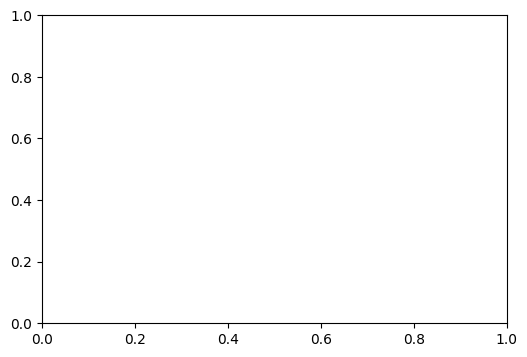

In [93]:
for run_idx, hparams in enumerate(ParameterGrid(grid), start=1):
    run_name = f"run_{run_idx}"
    writer = SummaryWriter(log_dir=f"runs/{run_name}")
    writer.add_hparams(hparams, {})
    
    train_loader = get_dataset(hparams,X_train_norm, y_train_encoded)
    model = pretrain(hparams, device, X_train_norm.shape[1], num_train_classes, train_loader, writer).to(device)
    model = fine_tune(model, hparams, device, train_loader, num_train_classes, writer).to(device)
    model.to('cpu')
    embd_train, embd_test = create_embeddings(model, X_train_norm, X_test_norm,hparams)
    
    train_acc, test_acc = get_accuracy(embd_train, embd_test, y_train_encoded, y_test_encoded)
    
    writer.add_scalar("Final_Accuracy/train", train_acc)
    writer.add_scalar("Final_Accuracy/test", test_acc)
    
    tsne_train = TSNE(n_components=2, random_state=42).fit_transform(embd_train)
    tsne_test = TSNE(n_components=2, random_state=42).fit_transform(embd_test)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    tsne_train_scaled = scaler.fit_transform(tsne_train)
    tsne_test_scaled = scaler.transform(tsne_test)
    
    fig_train = plot_tsne(tsne_train_scaled,
          cmap,
          y_train_encoded,
          handles=train_handles,
          alpha=0.5,
          title="TSNE Visualization training data XVector",
          xlabel="TSNE embedding dimension 1",
          ylabel="TSNE embedding dimension 2",
          centroids=None,
          return_fig=True)
    writer.add_figure("tsne_train", fig_train)
    fig_test = plot_tsne(tsne_test_scaled,
          cmap2,
          y_test_encoded,
          handles=test_handles,
          alpha=0.5,
          title="TSNE Visualization test data XVector",
          xlabel="TSNE embedding dimension 1",
          ylabel="TSNE embedding dimension 2",
          centroids=None, return_fig=True )
    embd_unit = embd_train / np.linalg.norm(embd_train, axis=1, keepdims=True)
    writer.add_figure("tsne_test", fig_test)
    
    fig = plot_distance_distribution_return(
        embeddings=embd_unit,
        participant_ids=np.array(y_train_encoded),
        distance_type="euclidean",
        bins=30
    )
    writer.add_figure("distance_distribution_euclidean", fig)
    
    fig = plot_distance_distribution_return(
        embeddings=embd_train,
        participant_ids=np.array(y_train_encoded),
        distance_type="cosine",
        bins=30
    )
    writer.add_figure("distance_distribution_cosine", fig)
    
    # train
    user_profiles = create_user_profiles(embd_train, np.array(y_train_encoded))
    for metric in ("euclidean", "cosine"):
        genuine_dists, imposter_dists = compute_genuine_imposter_distances(
                embeddings=embd_train ,
                ids=np.array(y_train_encoded),
                user_profiles=user_profiles,
                distance_metric=metric
            )
        
        (
            thresholds, fnr_list, fpr_list, acc_list,
            best_T, best_fnr, best_fpr, best_acc
        ) = compute_threshold_metrics(genuine_dists, imposter_dists, num_thresholds=200)
        
        fig = plot_threshold_metrics_return(
            thresholds, fnr_list, fpr_list, acc_list,
            best_T, best_fnr, best_fpr, best_acc
        )
        writer.add_figure(f"threshold_metrics_train_{metric}", fig)
        
        thresholds, f1_list, best_T, best_f1 = compute_f1_vs_threshold(
            genuine_dists, imposter_dists, num_thresholds=300
        )
        
        fig = plot_f1_vs_threshold_return(thresholds, f1_list, best_T, best_f1)
        writer.add_figure(f"f1_vs_threshold_train_{metric}", fig)
        

    # test
    profile_embd, profile_ids, verify_embd, verify_ids = split_test_data_for_verification(
        embd_test, np.array(y_test_encoded), profile_ratio=0.6
    )
    
    test_user_profiles = create_user_profiles(profile_embd, profile_ids)
    for metric in ("euclidean", "cosine"):
    
        genuine_dists, imposter_dists = compute_genuine_imposter_distances(
            embeddings=verify_embd,
            ids=verify_ids,
            user_profiles=test_user_profiles,
            distance_metric=metric
        )
        
        (
            test_thresholds, test_fnr_list, test_fpr_list, test_acc_list,
            test_best_T, test_best_fnr, test_best_fpr, test_best_acc
        ) = compute_threshold_metrics(genuine_dists, imposter_dists, num_thresholds=200)
        
        fig = plot_threshold_metrics_return(
            test_thresholds, test_fnr_list, test_fpr_list, test_acc_list,
            test_best_T, test_best_fnr, test_best_fpr, test_best_acc
        )
        writer.add_figure(f"threshold_metrics_test_{metric}", fig)
        
        test_thresholds_f1, test_f1_list, test_best_T_f1, test_best_f1 = compute_f1_vs_threshold(
            genuine_dists, imposter_dists, num_thresholds=300
        )
        
        fig = plot_f1_vs_threshold_return(test_thresholds_f1, test_f1_list, test_best_T_f1, test_best_f1)
        writer.add_figure(f"f1_vs_threshold_train_{metric}", fig)
    writer.close()                                                                                                                                 